In [8]:
import os
import argparse
from glob import glob
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import wandb

import jax
import jax.numpy as jnp

import torch
import torchvision.transforms as transforms

In [9]:
class GANDataset(torch.utils.data.Dataset):
    def __init__(self, args):
        self.args = args

        self.paths_a = glob('./data/trainA/*.jpg')
        self.paths_b = glob('./data/trainB/*.jpg')

        self.imgs_a = np.zeros(
            (len(self.paths_a), 32, 32, 3), dtype=np.float32)
        for i, path in tqdm(enumerate(self.paths_a)):
            img = np.asarray(Image.open(path)) / 255.0
            img = cv2.resize(img, dsize=(
                32, 32), interpolation=cv2.INTER_CUBIC).reshape(1, 32, 32, 3)
            self.imgs_a[i] = img

        self.imgs_b = np.zeros(
            (len(self.paths_b), 32, 32, 3), dtype=np.float32)
        for i, path in tqdm(enumerate(self.paths_b)):
            img = np.asarray(Image.open(path)) / 255.0
            img = cv2.resize(img, dsize=(
                32, 32), interpolation=cv2.INTER_CUBIC).reshape(1, 32, 32, 3)
            self.imgs_b[i] = img

        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(hue=0.15),
            transforms.RandomGrayscale(p=0.25),
            transforms.RandomRotation(35),
            transforms.RandomPerspective(distortion_scale=0.35),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def __len__(self):
        return len(self.paths_a)

    def __getitem__(self, index):
        img_a = self.imgs_a[index]
        img_b = self.imgs_b[index]

        img_a = self.transforms(img_a).numpy().transpose(1, 2, 0)
        img_b = self.transforms(img_b).numpy().transpose(1, 2, 0)
        # img_a = img_a.transpose(1, 2, 0)
        # img_b = img_b.transpose(1, 2, 0)

        return img_a, img_b

In [10]:
def shard(xs):
    return jax.tree_map(
        lambda x: x.reshape((jax.device_count(), -1) + x.shape[1:]), xs)

In [11]:
import flax
from flax import linen as nn

In [12]:
class IN(nn.Module):
    def __call__(self, x):
        # assuming an image in the format HxWxC
        mu = jnp.mean(x, axis=(1, 2), keepdims=True)
        sigma_2 = jnp.var(x, axis=(1, 2), keepdims=True)

        return (x - mu) / jnp.sqrt(sigma_2 + 1e-5)


class AdaIN(nn.Module):
    @nn.compact
    # assuming an image in the format HxWxC
    def __call__(self, content, style_mean, style_var):
        content_mu = jnp.mean(content, axis=(1, 2), keepdims=True)
        content_sigma_2 = jnp.var(content, axis=(1, 2), keepdims=True)

        normalized_content = (content - content_mu) / \
            jnp.sqrt(content_sigma_2 + 1e-5)

        return normalized_content * jnp.sqrt(style_var + 1e-5) + style_mean


class Block(nn.Module):
    padding: int
    features: int
    kernel_size: int
    strides: int
    norm: str = "none"

    @nn.compact
    def __call__(self, x, means=None, variances=None):
        x = jnp.pad(x, [(0, 0), (self.padding, self.padding),
                        (self.padding, self.padding), (0, 0)], mode='constant')

        if self.norm == "IN":
            x = IN()(x)
        # elif self.norm == 'AdaIN' and means is not None and variances is not None:
        #     x = AdaIN()(x, means, variances)

        x = nn.relu(x)
        x = nn.Conv(features=self.features, kernel_size=(self.kernel_size, self.kernel_size),
                    strides=(self.strides, self.strides), padding='VALID')(x)

        return x


class ResBlock(nn.Module):
    padding: int
    features: int
    kernel_size: int
    strides: int
    norm: str = "none"

    @nn.compact
    def __call__(self, x, means=None, variances=None):
        residual_branch = x

        x = Block(self.padding, self.features,
                  self.kernel_size, self.strides, self.norm)(x, means, variances)
        x = Block(self.padding, self.features,
                  self.kernel_size, self.strides, "none")(x, means, variances)

        return x + residual_branch


class StyleEncoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = Block(padding=3, features=64, kernel_size=7, strides=1)(x)

        x = Block(padding=1, features=64*2, kernel_size=4, strides=2)(x)
        x = Block(padding=1, features=64*2*2,
                  kernel_size=4, strides=2)(x)

        x = Block(padding=1, features=64*2*2,
                  kernel_size=4, strides=2)(x)
        x = Block(padding=1, features=64*2*2,
                  kernel_size=4, strides=2)(x)

        x = jnp.mean(x, axis=(1, 2), keepdims=True)
        x = nn.Conv(features=8, kernel_size=(1, 1),
                    strides=(1, 1), padding='VALID')(x)

        return x


class ContentEncoder(nn.Module):
    @nn.compact
    def __call__(self, x):

        x = Block(padding=3, features=64, kernel_size=7,
                  strides=1, norm='IN')(x)

        x = Block(padding=1, features=64*2,
                  kernel_size=4, strides=2, norm='IN')(x)
        x = Block(padding=1, features=64*2*2,
                  kernel_size=4, strides=2, norm='IN')(x)

        x = ResBlock(
            padding=1, features=64*2*2, kernel_size=3, strides=1, norm='IN')(x)
        x = ResBlock(
            padding=1, features=64*2*2, kernel_size=3, strides=1, norm='IN')(x)
        x = ResBlock(
            padding=1, features=64*2*2, kernel_size=3, strides=1, norm='IN')(x)
        x = ResBlock(
            padding=1, features=64*2*2, kernel_size=3, strides=1, norm='IN')(x)

        return x


class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256, use_bias=True)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256, use_bias=True)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256, use_bias=True)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256, use_bias=True)(x)
        x = nn.relu(x)
        x = nn.Dense(features=4*256*2, use_bias=True)(x)

        return x


class Decoder(nn.Module):
    @nn.compact
    def __call__(self, x, AdaIN_params):

        means = []
        variances = []
        for i in range(0, 4*256*2, 256*2):
            means_variances = AdaIN_params[:, :, :, i:i+256*2]
            means.append(means_variances[:, :, :, :256])
            variances.append(means_variances[:, :, :, 256:])
        
        x = ResBlock(padding=1, features=64*2*2, kernel_size=3,
                     strides=1, norm='AdaIN')(x, means[0], variances[0])
        x = ResBlock(padding=1, features=64*2*2, kernel_size=3,
                     strides=1, norm='')(x, means[1], variances[1])
        x = ResBlock(padding=1, features=64*2*2, kernel_size=3,
                     strides=1, norm='')(x, means[2], variances[2])
        x = ResBlock(padding=1, features=64*2*2, kernel_size=3,
                     strides=1, norm='')(x, means[3], variances[3])

        x = jax.image.resize(
            x, (x.shape[0], x.shape[1]*2, x.shape[2]*2, x.shape[3]), method=jax.image.ResizeMethod.NEAREST)
        x = Block(padding=2, features=64*2, kernel_size=5,
                  strides=1, norm='IN')(x)

        x = jax.image.resize(
            x, (x.shape[0], x.shape[1]*2, x.shape[2]*2, x.shape[3]), method=jax.image.ResizeMethod.NEAREST)
        x = Block(padding=2, features=64, kernel_size=5,
                  strides=1, norm='IN')(x)

        x = Block(padding=3, features=3, kernel_size=7, strides=1)(x)
        x = jnp.tanh(x)

        return x


class G_enc(nn.Module):
    @nn.compact
    def __call__(self, x):
        content = ContentEncoder()(x)
        style = StyleEncoder()(x)
        
        return content, style

class G_dec(nn.Module):
    @nn.compact
    def __call__(self, x, style):
        AdaIN_params = MLP()(style)
        out = Decoder()(x, AdaIN_params)
        return out

class D_part(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = jnp.pad(x, [(0, 0), (1, 1), (1, 1), (0, 0)], mode='constant')
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Conv(features=64, kernel_size=(4, 4),
                    strides=(2, 2), padding='VALID')(x)

        x = jnp.pad(x, [(0, 0), (1, 1), (1, 1), (0, 0)], mode='constant')
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Conv(features=64*2, kernel_size=(4, 4),
                    strides=(2, 2), padding='VALID')(x)

        x = jnp.pad(x, [(0, 0), (1, 1), (1, 1), (0, 0)], mode='constant')
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Conv(features=64*2*2, kernel_size=(4, 4),
                    strides=(2, 2), padding='VALID')(x)

        x = jnp.pad(x, [(0, 0), (1, 1), (1, 1), (0, 0)], mode='constant')
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Conv(features=64*2*2*2, kernel_size=(4, 4),
                    strides=(2, 2), padding='VALID')(x)

        x = nn.Conv(features=1, kernel_size=(1, 1),
                    strides=(1, 1), padding="VALID")(x)

        return x


class D(nn.Module):
    @nn.compact
    def __call__(self, x):
        outputs = []

        out = D_part()(x)
        outputs.append(out)

        x = nn.avg_pool(x, window_shape=(3, 3), strides=(
            2, 2), padding=((1, 1), (1, 1)))
        out = D_part()(x)
        outputs.append(out)

        x = nn.avg_pool(x, window_shape=(3, 3), strides=(
            2, 2), padding=((1, 1), (1, 1)))
        out = D_part()(x)
        outputs.append(out)

        return outputs

In [13]:
def l2_loss(logits, labels):
    loss = 0
    for i in range(3):
        loss +=jnp.mean((logits[i]-labels[i])**2)
    return loss

In [14]:
def l1_loss(logits, labels):
    return jnp.mean(jnp.abs(logits - labels))

In [15]:
def loss_g(g_params, d_params, x_s, x_t, rng):
    rng, rng_1, rng_2, rng_3 = jax.random.split(rng, 4)

    bs = x_s.shape[0]
    z_1 = jax.random.normal(rng_1, shape=(bs, 1, 1, 8))
    z_2 = jax.random.normal(rng_2, shape=(bs, 1, 1, 8))
    z_3 = jax.random.normal(rng_3, shape=(bs, 1, 1, 8))

    c_s, z_s = G_enc().apply({'params': g_params['g_s_enc']}, x_s)
    fake_s = G_dec().apply({'params': g_params['g_s_dec']}, c_s, z_1)

    c_t, z_t = G_enc().apply({'params': g_params['g_t_enc']}, x_s)
    fake_t = G_dec().apply({'params': g_params['g_t_dec']}, c_t, z_2)

    c_recon_s, z_recon_s = G_enc().apply(
        {'params': g_params['g_s_enc']}, fake_t)
    fake_recon_s = G_dec().apply(
        {'params': g_params['g_s_dec']}, c_recon_s, z_3)

    fake_idt_s = G_dec().apply(
        {'params': g_params['g_s_dec']}, c_s, z_s)
    fake_idt_t = G_dec().apply(
        {'params': g_params['g_t_dec']}, c_t, z_t)

    fake_logits_s = D().apply({'params': d_params['d_s']}, fake_s)
    fake_logits_t = D().apply({'params': d_params['d_t']}, fake_t)

    fake_logits_recon_s = D().apply(
        {'params': d_params['d_s']}, fake_recon_s)

    s_fake_s_logits = D().apply(
        {'params': d_params['d_hat']}, jnp.concatenate([x_s, fake_s], axis=3))
    s_fake_recon_s_logits = D().apply(
        {'params': d_params['d_hat']}, jnp.concatenate([x_s, fake_recon_s], axis=3))

    real_adv_labels = [jnp.ones_like(fake_logits_s[0]), jnp.ones_like(
        fake_logits_s[1]), jnp.ones_like(fake_logits_s[2])]
    real_acl_labels = [jnp.ones_like(s_fake_s_logits[0]), jnp.ones_like(
        s_fake_s_logits[1]), jnp.ones_like(s_fake_s_logits[2])]
    fake_acl_labels = [jnp.zeros_like(s_fake_s_logits[0]), jnp.zeros_like(
        s_fake_s_logits[1]), jnp.zeros_like(s_fake_s_logits[2])]

    loss_adv = l2_loss(fake_logits_t, real_adv_labels) + (l2_loss(fake_logits_s,
                                                                  real_adv_labels) + l2_loss(fake_logits_recon_s, real_adv_labels)) / 2
    loss_acl = l2_loss(s_fake_s_logits, real_acl_labels) + \
        l2_loss(s_fake_recon_s_logits, fake_acl_labels)
    loss_idt = l1_loss(x_s, fake_idt_s) + l1_loss(x_t, fake_idt_t)

    loss = loss_adv + 0.5 * loss_acl + loss_idt

    return loss

In [16]:
def loss_d(d_params, g_params, x_s, x_t, rng):
    rng, rng_1, rng_2, rng_3 = jax.random.split(rng, 4)

    bs = x_s.shape[0]
    z_1 = jax.random.normal(rng_1, shape=(bs, 1, 1, 8))
    z_2 = jax.random.normal(rng_2, shape=(bs, 1, 1, 8))
    z_3 = jax.random.normal(rng_3, shape=(bs, 1, 1, 8))

    c_s, z_s = G_enc().apply({'params': g_params['g_s_enc']}, x_s)
    fake_s = G_dec().apply({'params': g_params['g_s_dec']}, c_s, z_1)

    c_t, z_t = G_enc().apply({'params': g_params['g_t_enc']}, x_s)
    fake_t = G_dec().apply({'params': g_params['g_t_dec']}, c_t, z_2)

    c_recon_s, z_recon_s = G_enc().apply({'params': g_params['g_s_enc']}, fake_t)
    fake_recon_s = G_dec().apply({'params': g_params['g_s_dec']}, c_recon_s, z_3)

    real_logits_s = D().apply({'params': d_params['d_s']}, x_s)
    fake_logits_s = D().apply({'params': d_params['d_s']}, fake_s)

    real_logits_t = D().apply({'params': d_params['d_t']}, x_t)
    fake_logits_t = D().apply({'params': d_params['d_t']}, fake_t)

    real_logits_recon_s = D().apply({'params': d_params['d_s']}, x_s)
    fake_logits_recon_s = D().apply({'params': d_params['d_s']}, fake_recon_s)

    s_fake_s_logits = D().apply({'params': d_params['d_hat']}, jnp.concatenate([x_s, fake_s], axis=3))
    s_fake_recon_s_logits = D().apply({'params': d_params['d_hat']}, jnp.concatenate([x_s, fake_recon_s], axis=3))

    real_adv_labels = [jnp.ones_like(fake_logits_s[0]), jnp.ones_like(fake_logits_s[1]), jnp.ones_like(fake_logits_s[2])]
    fake_adv_labels = [jnp.zeros_like(fake_logits_s[0]), jnp.zeros_like(fake_logits_s[1]), jnp.zeros_like(fake_logits_s[2])]
    real_acl_labels = [jnp.ones_like(s_fake_s_logits[0]), jnp.ones_like(s_fake_s_logits[1]), jnp.ones_like(s_fake_s_logits[2])]
    fake_acl_labels = [jnp.zeros_like(s_fake_s_logits[0]), jnp.zeros_like(s_fake_s_logits[1]), jnp.zeros_like(s_fake_s_logits[2])]

    loss_adv = l2_loss(fake_logits_t, fake_adv_labels) + l2_loss(real_logits_t, real_adv_labels) + (l2_loss(fake_logits_s, fake_adv_labels) + l2_loss(real_logits_s, real_adv_labels) + l2_loss(fake_logits_recon_s, fake_adv_labels) + l2_loss(real_logits_recon_s, real_adv_labels)) / 2
    loss_acl = l2_loss(s_fake_s_logits, fake_acl_labels) + l2_loss(s_fake_recon_s_logits, real_acl_labels)

    loss = loss_adv + 0.5 * loss_acl

    return loss

In [17]:
rng = jax.random.PRNGKey(42)

init_x = jnp.ones((1, 64, 64, 3), jnp.float32)
init_encoded = jnp.ones((1, 16, 16, 256), jnp.float32)
init_z = jnp.zeros((1, 1, 1, 8), jnp.float32)
init_x_acl = jnp.ones((1, 64, 64, 6), jnp.float32)

variables_g_s_enc = G_enc().init(rng, init_x)
variables_g_s_dec = G_dec().init(rng, init_encoded, init_z)

variables_g_t_enc = G_enc().init(rng, init_x)
variables_g_t_dec = G_dec().init(rng, init_encoded, init_z)

variables_d_s = D().init(rng, init_x)
variables_d_t = D().init(rng, init_x)
variables_d_hat = D().init(rng, init_x_acl)

In [18]:
g_params = {
    'g_s_enc': variables_g_s_enc['params'],
    'g_s_dec': variables_g_s_dec['params'],
    'g_t_enc': variables_g_t_enc['params'],
    'g_t_dec': variables_g_t_dec['params'],
}

d_params = {
    'd_s': variables_d_s['params'],
    'd_t': variables_d_t['params'],
    'd_hat': variables_d_hat['params'],
}

In [19]:
x_s = jnp.ones((1, 64, 64, 3), jnp.float32)
x_t = jnp.ones((1, 64, 64, 3), jnp.float32)

In [20]:
x_s = shard(x_s)
x_t = shard(x_t)

In [21]:
rngs = jax.random.split(rng, num=jax.local_device_count())

In [22]:
optimizer_g = flax.optim.Adam(learning_rate=1e-2, beta1=0.5, beta2=0.9).create(g_params)
optimizer_g = flax.jax_utils.replicate(optimizer_g)

optimizer_d = flax.optim.Adam(learning_rate=1e-4, beta1=0.5, beta2=0.9).create(d_params)
optimizer_d = flax.jax_utils.replicate(optimizer_d)

In [25]:
rng, rng_sample = jax.random.split(rng)

z = jax.random.normal(rng, shape=(1, 1, 1, 8))

In [26]:
x = flax.jax_utils.unreplicate(x_s)

In [27]:
x.shape

(1, 64, 64, 3)

In [28]:
c, _ = G_enc().apply({'params': g_params['g_t_enc']}, x)
sample = G_dec().apply({'params': g_params['g_t_dec']}, c, z)

In [31]:
sample.shape

(1, 64, 64, 3)

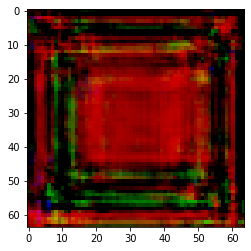

In [32]:
plt.imshow(sample.reshape(64, 64, 3))

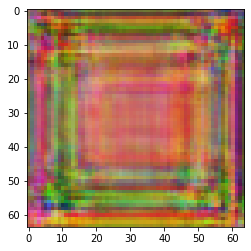

In [38]:
plt.imshow((sample.reshape(64, 64, 3) + 1) / 2)

In [59]:
@partial(jax.pmap, axis_name='batch')
def train_step(optimizer_g, optimizer_d, x_s, x_t, rng):
    g_loss, g_grad = jax.value_and_grad(loss_g)(optimizer_g.target, optimizer_d.target, x_s, x_t, rng)
    g_loss = jax.lax.pmean(g_loss, axis_name='batch')
    g_grad = jax.lax.pmean(g_grad, axis_name='batch')

    optimizer_g = optimizer_g.apply_gradient(g_grad)

    d_loss, d_grad = jax.value_and_grad(loss_d)(optimizer_d.target, optimizer_g.target, x_s, x_t, rng)
    d_loss = jax.lax.pmean(d_loss, axis_name='batch')
    d_grad = jax.lax.pmean(d_grad, axis_name='batch')

    optimizer_d = optimizer_d.apply_gradient(d_grad)

    return rng, optimizer_g, optimizer_d, g_loss, d_loss

In [60]:
rngs, optimizer_g, optimizer_d, g_loss = train_step(optimizer_g, optimizer_d, x_s, x_t, rngs)

In [61]:
g_loss

ShardedDeviceArray([9.176939], dtype=float32)